<a href="https://colab.research.google.com/github/zsteve/wtf/blob/main/examples/digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# setup git
# !git clone https://github.com/zsteve/wtf
# !pip install tensorly
# !pip install pot

In [1]:
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

In [2]:
import sys
sys.path.insert(0, "/home/zsteve/wtf/src")
import wtf

In [3]:
import numpy as np
import copy
import tensorly as tl
from tensorly import tenalg, decomposition, cp_tensor
from tensorly.contrib.sparse import tensor as sptensor
import ot
import torch
import sklearn 
from sklearn import datasets
import matplotlib.pyplot as plt
tl.set_backend("pytorch")
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tl_dtype = tl.float64

np.random.seed(0)

In [4]:
# mnist_data = sklearn.datasets.fetch_openml("mnist_784")
# 
# M = 500
# mnist_data.data = mnist_data.data[0:M, :]
# mnist_data.target = mnist_data.target[0:M]
# sizex, sizey = (28, 28)
# X = tl.tensor([wtf.normalise(x.reshape(sizex, sizey)) for x in mnist_data.data], dtype = tl.float64)
# plt.imshow(tl.unfold(X, 0))
# plt.axis("auto")
# plt.colorbar()
# 
# target = np.array([int(i) for i in mnist_data.target])
# 
# perm = np.random.permutation(M)
# train_idx = perm[:250]
# test_idx = perm[250:]
# X_test = X[test_idx]
# X_train = X[train_idx]
# 
# i = 2
# plt.title(target[i])
# plt.imshow(X[i, :, :])

In [5]:
# 8x8 digits dataset
M = 1500
N = 10
data_digits = sklearn.datasets.load_digits(n_class = N)
idx = np.random.choice(np.arange(data_digits.data.shape[0]), size = M)
data_digits.data = data_digits.data[idx]
data_digits.images = data_digits.images[idx]
data_digits.target = data_digits.target[idx]
target = data_digits.target

perm = np.random.permutation(M)
train_idx = perm[:750]
test_idx = perm[750:]

sizex, sizey = (8, 8)
X = tl.tensor([wtf.normalise(x) for x in data_digits.images], dtype = tl_dtype)
X = X/X.sum(-1).sum(-1).mean()

X_test = X[test_idx]
X_train = X[train_idx]

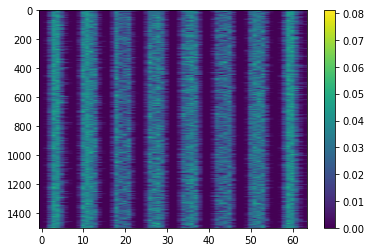

In [6]:
plt.imshow(tl.unfold(X, 0))
plt.axis("auto")
plt.colorbar()

In [7]:
xx, yy = np.meshgrid(range(sizex), range(sizey))
coords = np.vstack((xx.reshape(1, sizex*sizey), yy.reshape(1, sizex*sizey))).T
C_full = ot.utils.euclidean_distances(coords, coords, squared=True)
C_full = torch.Tensor(C_full/C_full.mean()).to(device)

In [8]:
# now pick multilinear rank
d = 3
r = [25, ]*3
S = tl.zeros(r).to(device)
for i in range(r[0]):
    S[i, i, i] = 1

RAND_STATE = 0

# initialise using SVD
factor_cp = tl.decomposition.non_negative_parafac(X_train, rank = r[0], n_iter_max = 0, init = "svd", random_state = RAND_STATE)
A = copy.deepcopy(factor_cp.factors)
A = [a.to(device) for a in A]
X0_train = X_train.to(device)

###

# good params
# n_iter = 10
# lr = np.ones(n_iter)*0.1
# lamda = np.array([np.ones(3), ]*n_iter)*10
# optim_modes = [0, ]
# rho = np.array([np.array([1, 1, 1]), ]*n_iter)*0.01
# eps = np.array([np.ones(3), ]*n_iter)*0.01
n_iter = 10
lr = np.ones(n_iter)*1
lamda = np.array([np.ones(3), ]*n_iter)*1
optim_modes = [0, ]
rho = np.array([np.array([1e-2, 1e-2, 1e-2]), ]*n_iter)
eps = np.array([np.ones(3), ]*n_iter)*0.01

In [9]:
A[0] = (A[0].T/A[0].sum(1)).T
A[1] = A[1]/A[1].sum(0)
A[2] = A[2]/A[2].sum(0)

In [10]:
dual_objs = [[], [], [], ]

In [11]:
import importlib
importlib.reload(wtf)

<module 'wtf' from '/home/zsteve/wtf/src/wtf.py'>

In [12]:
max_iter, print_inter, check_iter, tol, unbal = (100, 10, 10, 1e-2, True)
for i in range(n_iter):
    print("Block iteration ", i)
    print("Mode 0") 
    m0 = wtf.FactorsModel(X0_train, 0, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
    dual_objs[0] += [wtf.solve(m0, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[0] = m0.compute_primal_variable().detach()
    print("Mode 1") 
    m1 = wtf.FactorsModel(X0_train, 1, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[1] += [wtf.solve(m1, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[1] = m1.compute_primal_variable().detach()
    print("Mode 2") 
    m2 = wtf.FactorsModel(X0_train, 2, [C_full, ], S, A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "col")
    dual_objs[2] += [wtf.solve(m2, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol), ]
    A[2] = m2.compute_primal_variable().detach()
    # print("Core tensor")
    # m = wtf.CoreModel(X0_train, [C_full, ], A, rho[i, :], eps[i, :], lamda[i, :], ot_mode = "slice", device = device, unbal = unbal, norm = None)
    # wtf.solve(m, lr = lr[i], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = tol)
    # S = m.compute_primal_variable().detach()


Block iteration  0
Mode 0
i = 0 	 dual = 27.588377
i = 10 	 dual = 24.851619
Mode 1
i = 0 	 dual = 24.474298
i = 10 	 dual = 16.959993
i = 20 	 dual = 15.766213
i = 30 	 dual = 15.336895
i = 40 	 dual = 15.141474
i = 50 	 dual = 15.059538
i = 60 	 dual = 15.020615
i = 70 	 dual = 14.995888
i = 80 	 dual = 14.982432
Mode 2
i = 0 	 dual = 28.049536
i = 10 	 dual = 23.233504
i = 20 	 dual = 22.922277
i = 30 	 dual = 22.867425
i = 40 	 dual = 22.849931
Block iteration  1
Mode 0
i = 0 	 dual = 43.333990
i = 10 	 dual = 42.626301
i = 20 	 dual = 42.614299
Mode 1
i = 0 	 dual = 28.577138
i = 10 	 dual = 26.271915
i = 20 	 dual = 26.051192
i = 30 	 dual = 25.960391
i = 40 	 dual = 25.908902
i = 50 	 dual = 25.877120
i = 60 	 dual = 25.856428
i = 70 	 dual = 25.843683
Mode 2
i = 0 	 dual = 29.718571
i = 10 	 dual = 27.706978
i = 20 	 dual = 27.638809
i = 30 	 dual = 27.621658
Block iteration  2
Mode 0
i = 0 	 dual = 46.975814
i = 10 	 dual = 46.676146
i = 20 	 dual = 46.663229
Mode 1
i = 0 	 du

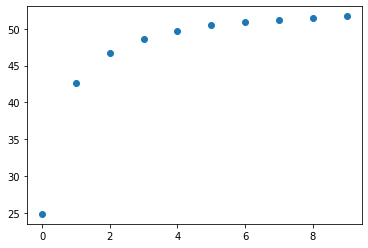

In [13]:
plt.scatter(np.arange(len(dual_objs[0])), dual_objs[0])

In [14]:
X_hat_train = tl.tenalg.multi_mode_dot(S, A).cpu()
factor_cp_train = tl.decomposition.non_negative_parafac(X_train, rank = r[0], init = "svd", n_iter_max = 500, random_state = RAND_STATE, tol = 1e-6)
X_cp_train = tl.cp_tensor.cp_to_tensor(factor_cp_train)

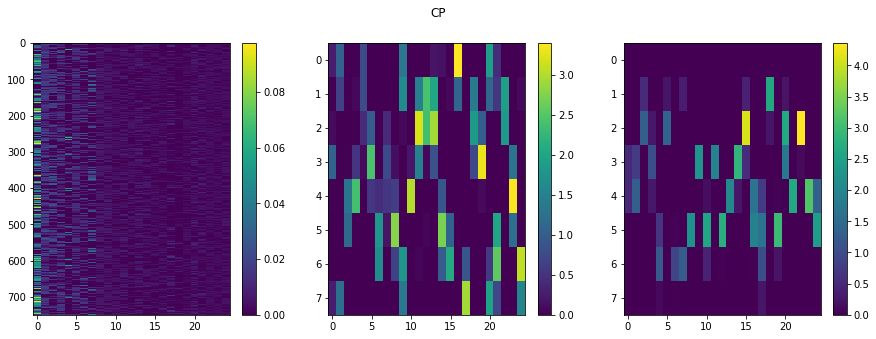

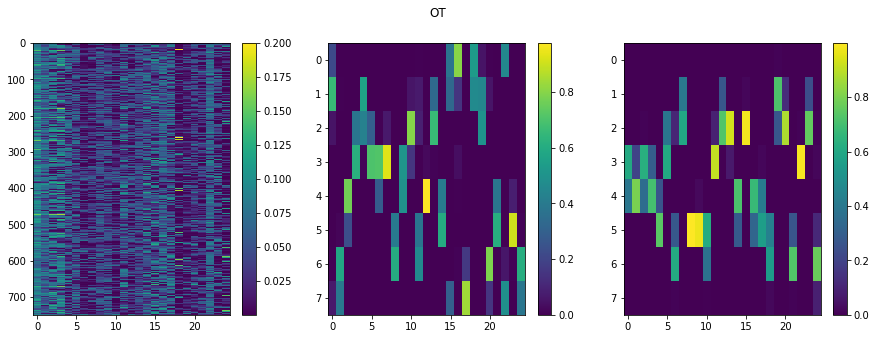

In [15]:
plt.figure(figsize = (15, 5))
plt.suptitle("CP")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(factor_cp_train.factors[i], interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

plt.figure(figsize = (15, 5))
plt.suptitle("OT")
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(A[i].cpu(), interpolation = "nearest")
    plt.axis("auto")
    plt.colorbar()

(-0.5, 624.5, 24.5, -0.5)

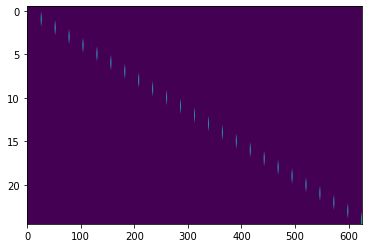

In [18]:
plt.imshow(tl.unfold(S, 0).cpu())
plt.axis("auto")

(-0.5, 749.5, 63.5, -0.5)

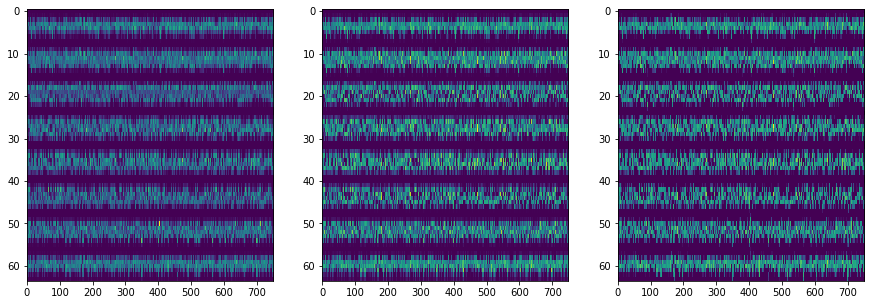

In [19]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_hat_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 2)
plt.imshow(X_cp_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")
plt.subplot(1, 3, 3)
plt.imshow(X_train.reshape(-1, sizex*sizey).T, interpolation = "nearest")
plt.axis("auto")

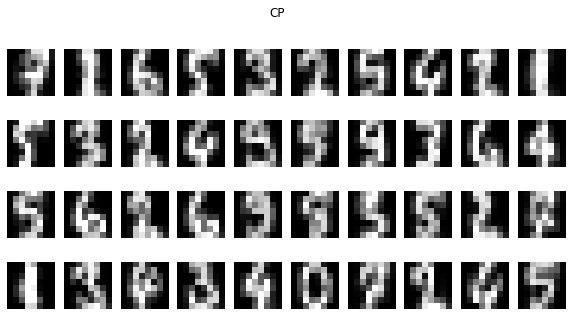

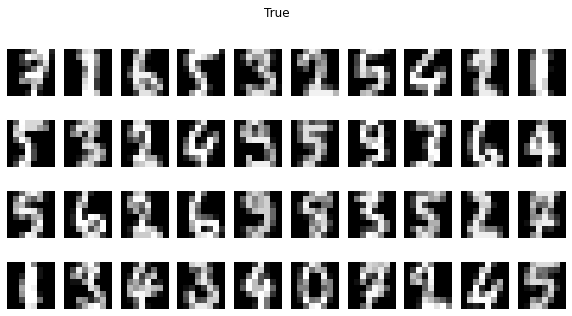

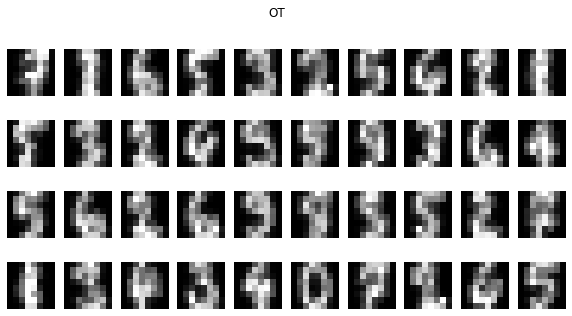

In [21]:
vmax = np.quantile(X_train, 0.95)
perm = np.random.permutation(X_train.shape[0])

plt.figure(figsize = (10, 5))
plt.suptitle("CP")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_cp_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("True")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

plt.figure(figsize = (10, 5))
plt.suptitle("OT")
for i in range(40):
    plt.subplot(4, 10, i+1)
    plt.imshow(X_hat_train[perm[i], :].reshape(sizex, sizey), vmin = 0, vmax = vmax, cmap = "gray")
    plt.axis("off")

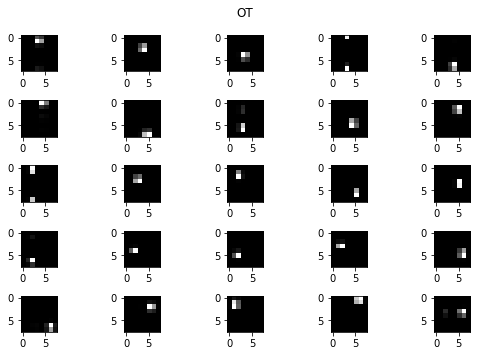

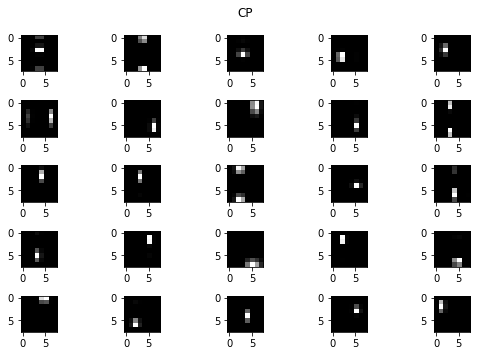

In [22]:
def outer(u, v):
    return u.reshape(-1, 1) * v.reshape(1, -1)

plt.figure(figsize = (7.5, 5))
plt.suptitle("OT")
perm = np.array(np.argsort(A[0].sum(0).cpu()))[::-1]
for i in range(r[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(outer(A[1][:, perm[i]], A[2][:, perm[i]]).cpu(), cmap = "gray")
plt.tight_layout()

plt.figure(figsize = (7.5, 5))
plt.suptitle("CP")
perm = np.array(np.argsort(factor_cp_train.factors[0].sum(0)))[::-1]
for i in range(r[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(outer(factor_cp_train.factors[1][:, perm[i]], factor_cp_train.factors[2][:, perm[i]]).cpu(), cmap = "gray")
plt.tight_layout()

In [24]:
from sklearn import cluster
kmeans = sklearn.cluster.KMeans(n_clusters = 10, n_init = 25)
def get_nmi_avg(M):
    clust = kmeans.fit_predict(M)
    return sklearn.metrics.normalized_mutual_info_score(target[train_idx], clust)

In [25]:
nmi_ot = np.array([get_nmi_avg(A[0].cpu()) for _ in range(10)])
nmi_cp = np.array([get_nmi_avg(factor_cp_train.factors[0]) for _ in range(10)])
nmi_ot, nmi_cp

(array([0.72036332, 0.74642281, 0.72047288, 0.78105545, 0.71965285,
        0.7087134 , 0.72322899, 0.7042238 , 0.70561872, 0.72846871]),
 array([0.41550433, 0.40519782, 0.4186673 , 0.4179455 , 0.39698827,
        0.41442852, 0.41442709, 0.40836746, 0.39624477, 0.40440082]))

In [26]:
nmi_ot.mean(), nmi_cp.mean()

(0.72582209261146, 0.409217187467725)

In [28]:
corr = lambda x, y: 1 - np.dot(x/np.linalg.norm(x), y/np.linalg.norm(y))
classif = {}

In [31]:
# SVM classifier
from sklearn import svm
from sklearn import neighbors
# clf = svm.SVC()
clf = neighbors.KNeighborsClassifier(n_neighbors = 1, metric = corr)
clf.fit(A[0].cpu(), target[train_idx])

# fit new coefficients
A_test = [tl.ones((X_test.shape[0], r[0]), dtype = tl_dtype), tl.copy(A[1]), tl.copy(A[2])]
m0 = wtf.FactorsModel(tl.tensor(X_test, dtype = tl_dtype).cuda(), 0, [C_full, ], S, A_test, rho[0, :], eps[0, :], lamda[0, :], 
                         ot_mode = "slice", U_init = None, device = device, unbal = unbal, norm = "row")
wtf.solve(m0, lr = lr[0], mode = "lbfgs", max_iter = max_iter, print_inter = print_inter, check_iter = check_iter, tol = 1e-3)
A_test[0] = m0.compute_primal_variable().detach()

err_train = (clf.predict(A[0].cpu()) != target[train_idx]).mean() # train error
err_test = (clf.predict(A_test[0].cpu()) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

/opt/conda/lib/python3.7/site-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


i = 0 	 dual = 51.743855
i = 10 	 dual = 51.591813
i = 20 	 dual = 51.585924
i = 30 	 dual = 51.584338
err_train =  0.0  err_test =  0.030666666666666665


In [35]:
# SVM classifier for Frobenius-CP
# clf_cp = svm.SVC()
clf_cp = neighbors.KNeighborsClassifier(n_neighbors = 1, metric = corr)
clf_cp.fit(factor_cp_train.factors[0], target[train_idx])
cp_fitter = sklearn.decomposition.NMF()
cp_fitter.n_components_ = r[0]
cp_fitter.components_ = np.array(tl.tenalg.khatri_rao(factor_cp_train.factors[1:])).T
coeffs = cp_fitter.transform(tl.unfold(X_test, 0))
err_train = (clf_cp.predict(factor_cp_train.factors[0]) != target[train_idx]).mean() # train error
err_test = (clf_cp.predict(coeffs) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.0  err_test =  0.08266666666666667


In [37]:
# SVM classifier for PCA
pca = sklearn.decomposition.PCA(n_components = r[0])
X_train_pca = pca.fit_transform(tl.unfold(X_train, 0))
X_test_pca = pca.transform(tl.unfold(X_test, 0))
# clf_pca = svm.SVC()
clf_pca = neighbors.KNeighborsClassifier(n_neighbors = 1, metric = corr)
clf_pca.fit(X_train_pca, target[train_idx])
err_train = (clf_pca.predict(X_train_pca) != target[train_idx]).mean() # train error
err_test = (clf_pca.predict(X_test_pca) != target[test_idx]).mean() # test error
print("err_train = ", err_train, " err_test = ", err_test)

err_train =  0.0  err_test =  0.016
